In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
import sys
os.chdir('drive/Colab Notebooks/Sentiment')

In [42]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import re
import tensorflow
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, Phrases
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix
tensorflow.random.set_seed(123)
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM , Embedding, Dropout ,Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import load_model
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
sentence = pd.read_csv("4_sentence.csv", delimiter = '\t', header = None)
train_size = int(0.7 * sentence.shape[0])
train = sentence.iloc[0:train_size,:]
test = sentence.iloc[train_size:, :]
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

In [44]:
def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

def lemmatize(tokens: list) -> list:
    # Lemmatize 词形还原 去掉单词的词缀 
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 删除停用词
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # Clean text
    review = clean_review(review)
    # Split into individual words
    tokens = word_tokenize(review)
    # Lemmatize
    lemmas = lemmatize(tokens)
    # Join the words back into one string separated by space
    return lemmas

In [45]:
df1 = pd.read_csv('labeledTrainData.tsv', delimiter="\t")
df1 = df1.drop(['id'], axis=1)
df1.columns = [0,1]
train = pd.concat([df1.iloc[0:5000,:],train], axis = 0)
train['Processed_Reviews'] = train[1].apply(lambda x: clean_text(x))
train.head()

,0,1,Processed_Reviews
0,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...
2,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


In [46]:
print(train.shape)
print(test.shape)

(6923, 3)
(825, 2)


In [47]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(train['Processed_Reviews'])

maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = train[0]

In [ ]:
'''

embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(8, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(5, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 10
history = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training & Validation Loss")

In [48]:
test[1]=test[1].apply(lambda x: clean_text(x))
y_test = test[0]
list_sentences_test = test[1]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Accuracy: 0.8109090909090909
F1-score: 0.7903225806451614
Recall-score: 0.828169014084507
Confusion matrix:


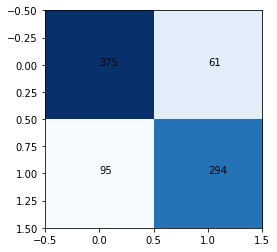

In [50]:
from keras.models import load_model
model = load_model("sent.h5")
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)
print('Accuracy: {0}'.format(accuracy_score(y_pred, y_test)))
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Recall-score: {0}'.format(recall_score(y_pred, y_test)))
print('Confusion matrix:')
confusion = confusion_matrix(y_pred, y_test)
plt.imshow(confusion, cmap=plt.cm.Blues)
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])